In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import time

from model import proxy_crm_modules as pCRM
from pywaterflood import CrmCompensated

In [2]:
np.set_printoptions(threshold=np.inf)

<h3><b>1. Data Preprocessing</b></h3>
<p>Here, we process data for better understanding of the structure and plan out the things we need to do toward the data.</p>

In [3]:
# For CRM
data_src = "https://github.com/leleony/proxy_crm/raw/master/data/"
prod_xls = pd.ExcelFile(data_src + "UNISIM_PROD.xlsx")
prod_bloto_alto = pd.read_excel(prod_xls, 'BlotoAlto', header=None)
prod_bloto_baixo = pd.read_excel(prod_xls, 'BlotoBaixo', header=None)

inj_xls = pd.ExcelFile(data_src + "UNISIM_INJ.xlsx")
inj_bloto_alto = pd.read_excel(inj_xls, 'BlotoAlto', header=None)
inj_bloto_baixo = pd.read_excel(inj_xls, 'BlotoBaixo', header=None)

bhp_xls = pd.ExcelFile(data_src + "UNISIM_BHP.xlsx")
bhp_bloto_alto = pd.read_excel(bhp_xls, 'BlotoAlto', header=None)
bhp_bloto_baixo = pd.read_excel(bhp_xls, 'BlotoBaixo', header=None)

t = pd.read_excel(data_src + "UNISIM_TIME.xlsx", header= None)

<h3><b>Apply CRM Model</b></h3>
<p>In this part, there are several cases that will be tackled using proxy-CRM model from proxyCRM_modules:<br><br>
1. <b>Case 1</b>: No shut-in well case.<br>
2. <b>Case 2</b>: One and multiple shut-in case.<br>
3. <b>Case 3</b>: One and multiple shut-in and well treatment case.</p><br>

In [4]:
train_size = int(0.875 * t.shape[0])

In [5]:
inj_train = inj_bloto_alto.values[:train_size]
prod_train = prod_bloto_alto.values[:train_size]
time_train = t.values[:train_size].astype(float)
bhp_train = bhp_bloto_alto.values[:train_size]

inj_test = inj_bloto_alto.values[train_size:]
prod_test = prod_bloto_alto.values[train_size:]
time_test = t.values[train_size:].astype(float)
bhp_test = bhp_bloto_alto.values[train_size:]

USING PROXY-CRM

In [6]:
bloto_alto = pCRM.proxyCRM()

In [7]:
start_time = time.time()
bloto_alto.fit(prod_train, inj_train, bhp_train, time_train[:,0], ftol=5e-3, num_cores=4)

print("=" * 20)
print("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[      fun: 87.81726199885189
 hess_inv: <143x143 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.06858760e+00, -2.80210486e+00, -2.59827857e+00, -1.20185177e+00,
        2.27058195e+00,  2.54420058e+00, -2.63956679e+00,  8.66251071e-01,
       -4.56239491e-01,  1.19028272e+01, -2.33295055e+00, -1.59946012e-01,
        2.54010502e-01,  8.40634869e+00,  5.63416052e+00,  1.12453336e+00,
        2.03380353e+00,  1.52360258e-01,  1.58071913e+01, -1.94545322e+00,
       -5.13313268e+00, -1.23147572e+00, -5.06052800e-01,  1.18047666e+01,
       -6.48662422e+00, -6.14640783e-01, -2.80068093e+00,  8.21287358e+00,
        9.94764946e+00,  5.32962758e+00,  1.14486468e+01,  2.21035080e+01,
        1.36829499e+01,  1.76709591e+01,  2.47547973e+00,  1.14939780e+01,
       -4.30778186e+00, -7.22423011e-02, -1.42488403e+00,  1.00902469e+00,
       -4.85595564e+00,  1.46652042e+00, -2.03065724e+00, -1.36263338e+00,
        2.78278378e-01, -8.26773033e+00, -2.13168079e+00, -5.75064974e-01,

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 10.3min finished


In [8]:
q_hat_train = bloto_alto.predict()
q_hat_test = bloto_alto.predict(inj=inj_test, time=time_test[:,0].astype(float), prod = prod_test, press = bhp_test)

USING CRMIP

In [9]:
crm = CrmCompensated(tau_selection='per-pair', constraints='up-to one')

start_time = time.time()
crm.fit(prod_train, bhp_train, inj_train, time_train[:,0])
print("=" * 20)
print("--- %s seconds ---" % (time.time() - start_time))

--- 852.0749101638794 seconds ---


In [10]:
q_hat_crmip = crm.predict()
q_hat_crmip_test = crm.predict(injection = inj_test, time = time_test[:,0], production=prod_test)

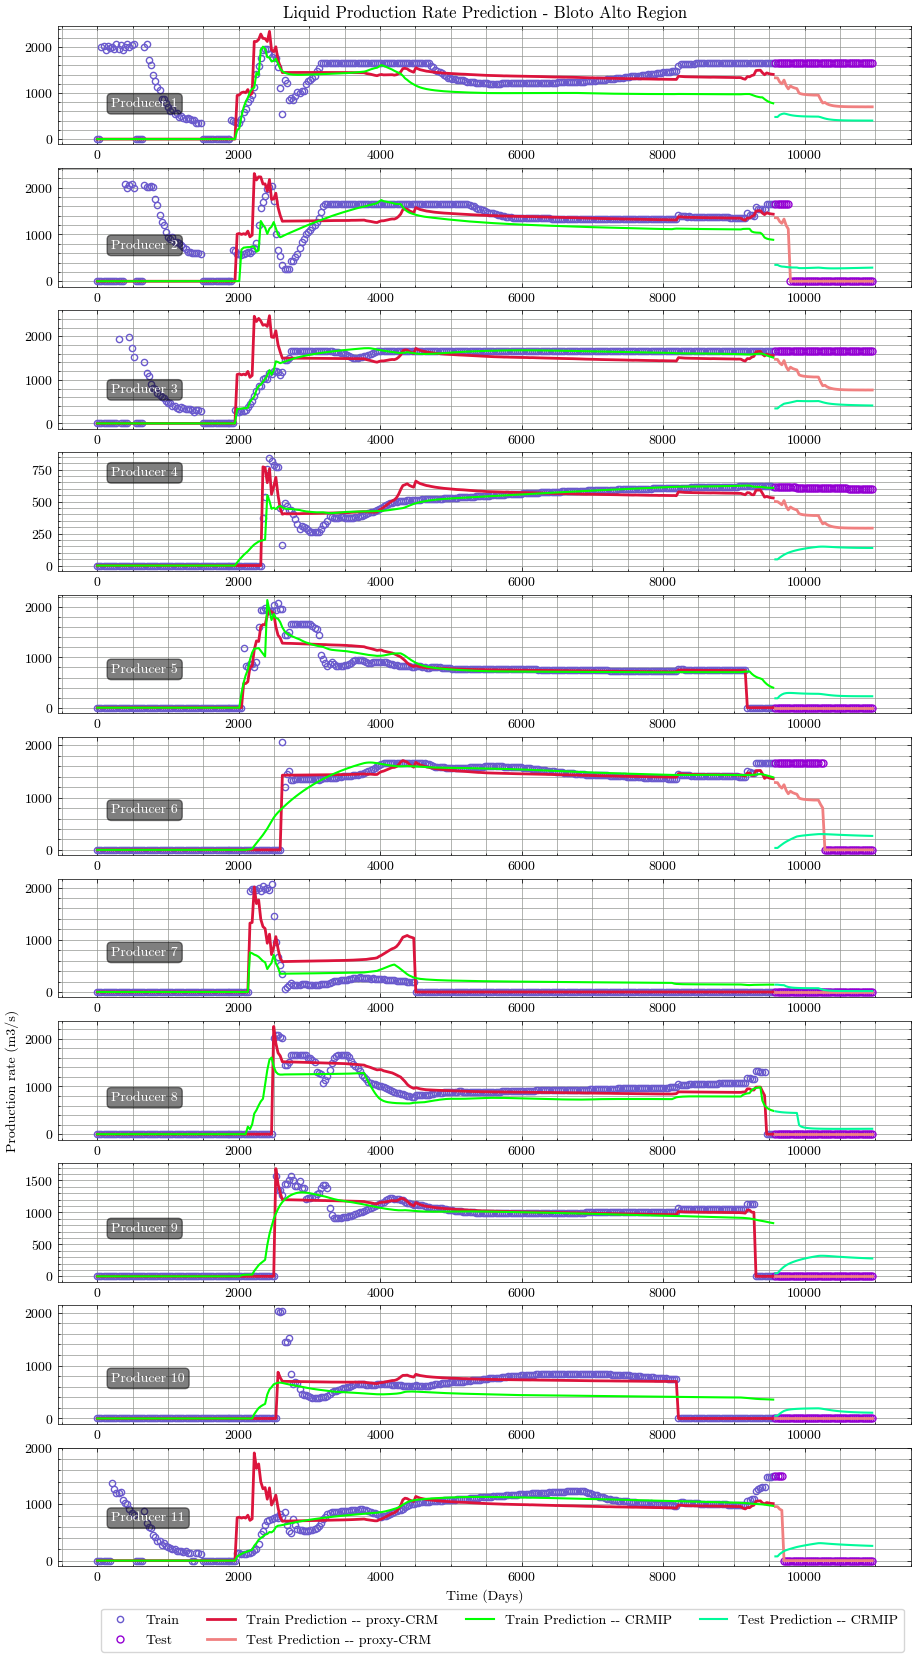

In [11]:
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(len(prod_bloto_alto.columns), figsize=(11, 20))
for i, p in enumerate(prod_bloto_alto):
    axes[i].plot(time_train , prod_train[:,i], label=f"Train", marker="o", markerfacecolor='None', markersize=4.5, ls='None', color='slateblue')
    axes[i].plot(time_test, prod_test[:,i], label=f"Test", marker="o", markerfacecolor='None', markersize=5, ls='None', color='darkviolet')
    axes[i].plot(time_train, q_hat_train[:,i], label=f"Train Prediction -- proxy-CRM", lw=2, color='crimson')
    axes[i].plot(time_test, q_hat_test[:,i], label=f"Test Prediction -- proxy-CRM", lw=2, color='lightcoral')
    axes[i].plot(time_train, q_hat_crmip[:,i], label=f"Train Prediction -- CRMIP", lw=1.5, color='lime')
    axes[i].plot(time_test, q_hat_crmip_test[:,i], label=f"Test Prediction -- CRMIP", lw=1.5, color='mediumspringgreen')
    
    axes[i].annotate(f"Producer {p+1}", xy=(200, 700), color='white', bbox=dict(boxstyle='round',pad=0.3, edgecolor='black', facecolor='black', alpha=0.5))
    axes[i].grid(visible=True, which='both', color='#929591')
axes[i].set(xlabel="Time (Days)")
axes[7].set(ylabel="Production rate (m3/s)")
axes[0].set(title='Liquid Production Rate Prediction - Bloto Alto Region')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

In [13]:
# get directory
import os
parentDir = os.path.abspath(os.getcwd())

In [15]:
connectivity = pd.DataFrame(
    bloto_alto.lambda_ip.reshape((prod_bloto_alto.shape[1], inj_bloto_alto.shape[1])),
    index=prod_bloto_alto.columns.rename("Producer"),
    columns=inj_bloto_alto.columns.rename("Injector"),
)
conn_table = connectivity.T.style.highlight_max(color='blue').format("{:.2}")

conn_table.to_excel(os.path.join(parentDir, 'data\\results', 'bloto_alto_lambda_ip.xlsx')) # exporting results to excel files

conn_table

Producer,0,1,2,3,4,5,6,7,8,9,10
Injector,,,,,,,,,,,
0,0.0093,0.0,0.0,0.048,0.052,0.12,0.057,0.074,0.085,0.049,0.0
1,0.12,0.093,0.085,0.0068,0.11,0.089,0.0,0.12,0.072,0.031,0.0014
2,0.13,0.13,0.15,0.038,0.1,0.099,0.016,0.14,0.089,0.064,0.095
3,0.099,0.066,0.078,0.0,0.093,0.084,0.0,0.11,0.066,0.024,0.0055
4,0.13,0.14,0.15,0.066,0.014,0.13,0.13,0.0075,0.07,0.074,0.1
5,0.0,0.0,0.0,0.0,0.071,0.052,0.015,0.081,0.051,0.003,0.0
6,0.16,0.19,0.19,0.056,0.044,0.12,0.11,0.05,0.077,0.064,0.17
7,0.072,0.045,0.087,0.0097,0.12,0.059,0.0,0.13,0.088,0.061,0.0045
8,0.087,0.049,0.085,0.0,0.11,0.041,0.0,0.14,0.072,0.024,0.0084


In [16]:
def rmse(test, pred):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  return original_rmse

result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_test[:,j])))

print(f'Test Prediction RMSE of Bloto Alto using proxy-CRM:\n{np.array(result)}')

Test Prediction RMSE of Bloto Alto using proxy-CRM:
[794.83339196 155.87215228 711.57358686 253.16737804   0.
 440.0270186    0.           0.           0.           0.
 168.31639828]


In [17]:
result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_crmip_test[:,j])))

print(f'Test Prediction RMSE of Bloto Alto using CRMIP:\n{np.array(result)}')

Test Prediction RMSE of Bloto Alto using CRMIP:
[1200.96944747  582.4249815  1203.99074778  478.50960866  254.61947029
 1036.40030604   67.92526076  246.60259621  272.78340871  151.15439116
  487.2368802 ]


In [18]:
result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_train[:,j], q_hat_train[:,j])))

print(f'Train Prediction RMSE of Bloto Alto using proxy-CRM:\n{np.array(result)}')

Train Prediction RMSE of Bloto Alto using proxy-CRM:
[577.38391035 522.63072428 412.00905072  62.33753649 161.81136429
  77.58748692 264.86905857 146.86187319  80.45725685 171.93878006
 330.50114187]


In [19]:
result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_train[:,j], q_hat_crmip[:,j])))

print(f'Train Prediction RMSE of Bloto Alto using CRMIP:\n{np.array(result)}')

Train Prediction RMSE of Bloto Alto using CRMIP:
[644.3804783  518.6857395  280.26934785  66.20497382 192.34913865
 152.65376101 302.81215256 286.03750387 194.58863937 318.15752228
 248.64392214]


BLOTO-BAIXO CASE

In [20]:
inj_train2 = inj_bloto_baixo.values[:train_size]
prod_train2 = prod_bloto_baixo.values[:train_size]
time_train2 = t.values[:train_size].astype(float)
bhp_train2 = bhp_bloto_baixo.values[:train_size]

inj_test2 = inj_bloto_baixo.values[train_size:]
prod_test2 = prod_bloto_baixo.values[train_size:]
time_test2 = t.values[train_size:].astype(float)
bhp_test2 = bhp_bloto_baixo.values[train_size:]

In [21]:
start_time = time.time()
proxy_crm = pCRM.proxyCRM()
proxy_crm.fit(prod_train2, inj_train2, bhp_train2, time_train2[:,0], num_cores=4)
print("=" * 20)
print("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[      fun: 9.928782707685231
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.78989285e-02, -1.22373223e-03,  7.47888862e-02, -4.73196593e-02,
        1.66730674e+01,  2.37674769e-02, -5.79092282e-05, -2.80131450e-04,
       -1.67865707e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.13093535e-02,
       -1.93693950e-02, -2.03710826e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 228
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([ 0.10989177,  0.4542505 ,  0.40655065,  0.33433036,  0.        ,
        0.42649288,  9.99998659, 10.        , 10.        ,  1.        ,
        1.        ,  1.        , 10.        , 10.        , 10.        ,
        0.10144639,  0.10333798,  0.10432821])]

lambda_ip: [0.10989177 0.4542505  0.40655065 0.33433036 0.         0.42649288]
tau: [ 9.99998659 10.         10.        ]
lambda_prod: [1. 1. 1.]
tau_

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.5s finished


In [22]:
q_hat_train2 = proxy_crm.predict()
q_hat_test2 = proxy_crm.predict(inj=inj_test2, time=time_test2[:,0].astype(float), prod = prod_test2, press = bhp_test2)

USING CRMIP

In [23]:
crm2 = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm2.fit(prod_train2, bhp_train2, inj_train2, time_train2[:,0], num_cores=4)

In [24]:
q_hat_crmip2 = crm2.predict()
q_hat_crmip_test2 = crm2.predict(injection = inj_test2, time = time_test2[:,0].astype(float), production=prod_test2)

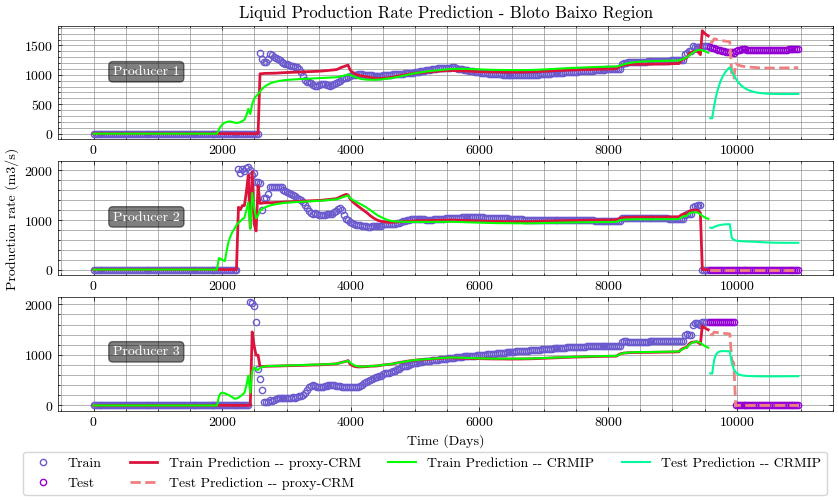

In [25]:
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(len(prod_bloto_baixo.columns), figsize=(10, 5))
for i, p in enumerate(prod_bloto_baixo):
    axes[i].plot(time_train , prod_train2[:,i], label=f"Train", marker="o", markerfacecolor='None', markersize=4.5, ls='None', color='slateblue')
    axes[i].plot(time_test, prod_test2[:,i], label=f"Test", marker="o", markerfacecolor='None', markersize=4.5, ls='None', color='darkviolet')
    axes[i].plot(time_train, q_hat_train2[:,i], label=f"Train Prediction -- proxy-CRM", lw=2, color='crimson')
    axes[i].plot(time_test, q_hat_test2[:,i], ls="--", label=f"Test Prediction -- proxy-CRM", lw=2, color='lightcoral')
    axes[i].plot(time_train, q_hat_crmip2[:,i], label=f"Train Prediction -- CRMIP", lw=1.5, color='lime')
    axes[i].plot(time_test, q_hat_crmip_test2[:,i], label=f"Test Prediction -- CRMIP", lw=1.5, color='mediumspringgreen')
    axes[i].annotate(f"Producer {p+1}", xy=(300, 1000), color='white', bbox=dict(boxstyle='round', pad=0.3, edgecolor='black', facecolor='black', alpha=0.5))
    axes[i].grid(visible=True, which='both', color='#929591')
axes[i].set(xlabel="Time (Days)")
axes[1].set(ylabel="Production rate (m3/s)")
axes[0].set(title='Liquid Production Rate Prediction - Bloto Baixo Region')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

In [26]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip.reshape((prod_bloto_baixo.shape[1], inj_bloto_baixo.shape[1])),
    index=prod_bloto_baixo.columns.rename("Producer"),
    columns=inj_bloto_baixo.columns.rename("Injector"),
)
conn_table = connectivity.T.style.highlight_max(color='blue').format("{:.2}")

conn_table.to_excel(os.path.join(parentDir, 'data\\results', 'bloto_baixo_lambda_ip.xlsx')) # exporting results to excel files

conn_table

Producer,0,1,2
Injector,,,
0,0.11,0.41,0.0
1,0.45,0.33,0.43


In [27]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_test2[:,j], q_hat_test2[:,j])))

print(f'Test Prediction RMSE of Bloto Baixo using proxy-CRM:\n{np.array(result)}')

Test Prediction RMSE of Bloto Baixo using proxy-CRM:
[278.73955922   0.         198.98476788]


In [28]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_test2[:,j], q_hat_crmip_test2[:,j])))

print(f'Test Prediction RMSE of Bloto Baixo using CRMIP:\n{np.array(result)}')

Test Prediction RMSE of Bloto Baixo using CRMIP:
[707.2115452  650.80479763 630.14528532]


In [29]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_train2[:,j], q_hat_train2[:,j])))

print(f'Train Prediction RMSE of Bloto Baixo using proxy-CRM:\n{np.array(result)}')

Train Prediction RMSE of Bloto Baixo using proxy-CRM:
[ 90.26641334 185.64119505 286.37678944]


In [30]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_train2[:,j], q_hat_crmip2[:,j])))

print(f'Train Prediction RMSE of Bloto Baixo using CRMIP:\n{np.array(result)}')

Train Prediction RMSE of Bloto Baixo using CRMIP:
[138.45014123 265.96388599 306.56631565]
